<a href="https://colab.research.google.com/github/Daesere/551Assignments/blob/main/551A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Data acquisition, preprocessing, and exploration

## 1.1 Loading the data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving day.csv to day.csv
Saving hour.csv to hour.csv


In [27]:
import pandas as pd
import io

day_df = pd.read_csv(io.BytesIO(uploaded['day.csv']))


In [28]:
print(day_df.shape[0], day_df.shape[1], day_df.dtypes)

731 16 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


## 1.2 Data cleaning and preprocessing

In [29]:
# Check for missing values (should be none according to dataset website)
check_nan_day = day_df.isnull().values.any()

print(check_nan_day)

False


In [30]:
# Drop IDs
day_df.drop('instant', axis=1, inplace=True)

# Drop casual and registered (cnt = casual + registered) to prevent data leakage
day_df.drop('casual', axis=1, inplace=True)
day_df.drop('registered', axis=1, inplace=True)
# drop dteday since yr represents the same thing
day_df.drop('dteday', axis=1, inplace=True)
print(day_df)

     season  yr  mnth  holiday  weekday  workingday  weathersit      temp  \
0         1   0     1        0        6           0           2  0.344167   
1         1   0     1        0        0           0           2  0.363478   
2         1   0     1        0        1           1           1  0.196364   
3         1   0     1        0        2           1           1  0.200000   
4         1   0     1        0        3           1           1  0.226957   
..      ...  ..   ...      ...      ...         ...         ...       ...   
726       1   1    12        0        4           1           2  0.254167   
727       1   1    12        0        5           1           2  0.253333   
728       1   1    12        0        6           0           2  0.253333   
729       1   1    12        0        0           0           1  0.255833   
730       1   1    12        0        1           1           2  0.215833   

        atemp       hum  windspeed   cnt  
0    0.363625  0.805833   0.1604

In [85]:
import numpy as np
# Encode categorical features as either one-hot or cyclical
day_df_cg = day_df.copy(deep=True) # Save copy for plots
# Perform sin/cosine transformations

def cyclical_transform(x, period):
    x_sin = np.sin(2 * np.pi * x / period)
    x_cos = np.cos(2 * np.pi * x / period)
    return x_sin, x_cos

def preprocess_bike_data(df, sincos=False):
    df_processed = df.copy()
    if sincos:
      df_processed['mnth_sin'] = np.sin(2 * np.pi * df['mnth'] / 12)
      df_processed['mnth_cos'] = np.cos(2 * np.pi * df['mnth'] / 12)
      df_processed['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
      df_processed['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
      df_processed['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
      df_processed['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)
      df_processed.drop(columns=['mnth','weekday','season'], axis=1, inplace=True)
      if 'hr' in df.columns:
          df_processed['hr_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
          df_processed['hr_cos'] = np.cos(2 * np.pi * df['hr'] / 24)
          df_processed.drop(columns=['hr'])

    weather_encoded = pd.get_dummies(df['weathersit'], prefix='weather', drop_first=True, dtype=int)

    df_processed.drop(columns=['weathersit'], axis=1, inplace=True)

    df_processed = pd.concat([df_processed, weather_encoded], axis=1)

    return df_processed

day_df_processed = preprocess_bike_data(day_df,sincos=False)
day_df_processed_sincos = preprocess_bike_data(day_df,sincos=True)

print(day_df_processed_sincos)

     yr  holiday  workingday      temp     atemp       hum  windspeed   cnt  \
0     0        0           0  0.344167  0.363625  0.805833   0.160446   985   
1     0        0           0  0.363478  0.353739  0.696087   0.248539   801   
2     0        0           1  0.196364  0.189405  0.437273   0.248309  1349   
3     0        0           1  0.200000  0.212122  0.590435   0.160296  1562   
4     0        0           1  0.226957  0.229270  0.436957   0.186900  1600   
..   ..      ...         ...       ...       ...       ...        ...   ...   
726   1        0           1  0.254167  0.226642  0.652917   0.350133  2114   
727   1        0           1  0.253333  0.255046  0.590000   0.155471  3095   
728   1        0           0  0.253333  0.242400  0.752917   0.124383  1341   
729   1        0           0  0.255833  0.231700  0.483333   0.350754  1796   
730   1        0           1  0.215833  0.223487  0.577500   0.154846  2729   

         mnth_sin  mnth_cos  weekday_sin  weekday_c

## 1.3 Data visualization and exploratory analysis

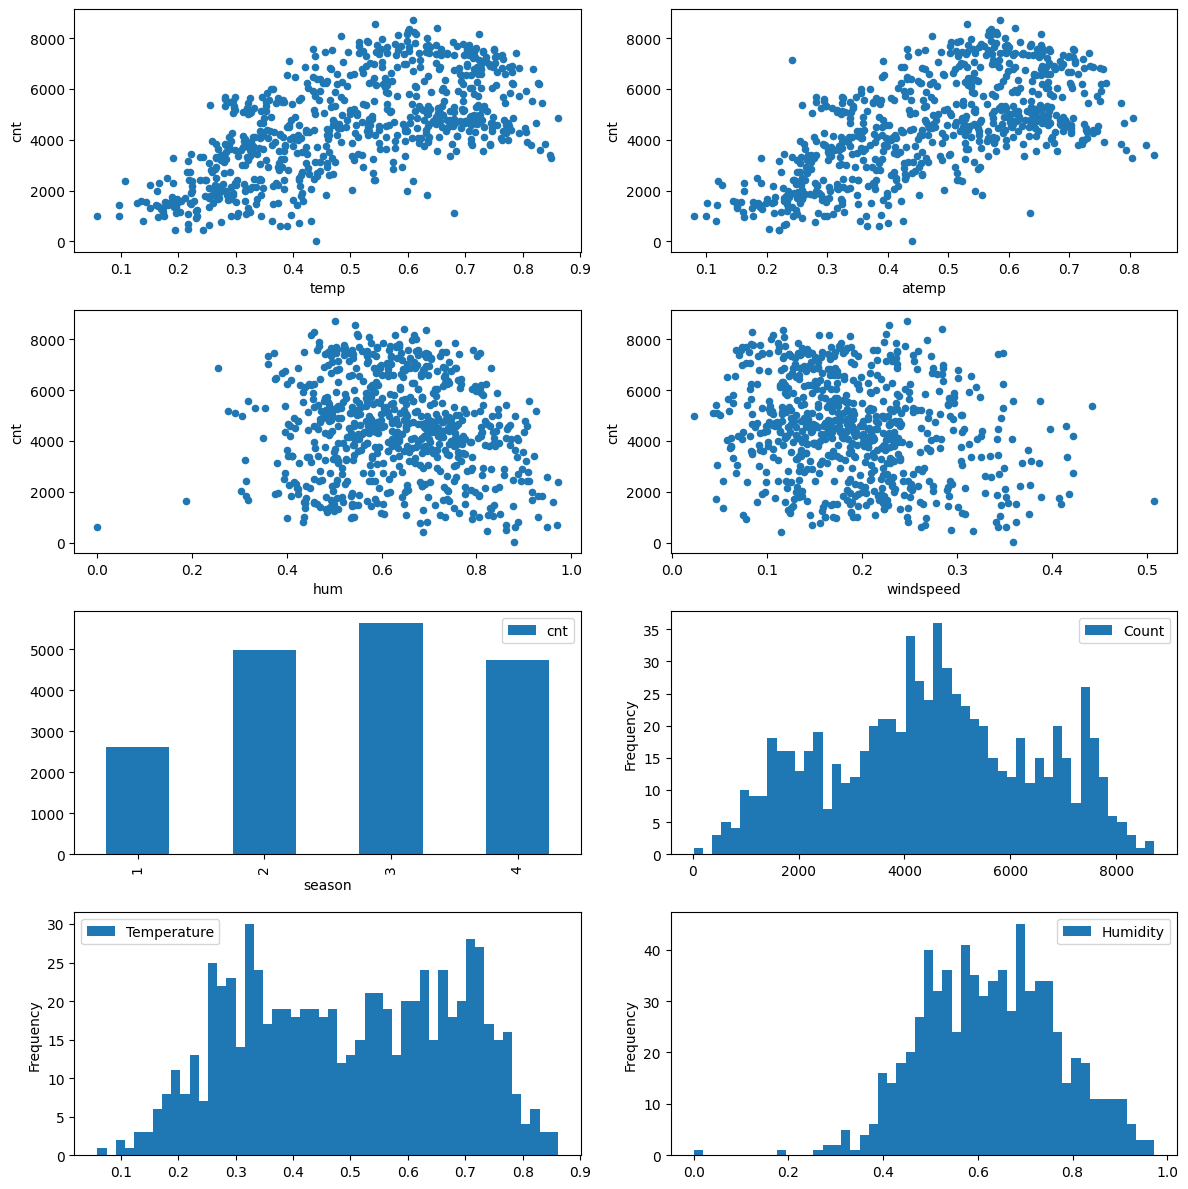

In [72]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

day_df.plot.scatter(x="temp", y="cnt", ax=axs[0, 0])
day_df.plot.scatter(x="atemp", y="cnt", ax=axs[0, 1])
day_df.plot.scatter(x="hum", y="cnt", ax=axs[1, 0])
day_df.plot.scatter(x="windspeed", y="cnt", ax=axs[1, 1])

day_df_cg.groupby("season", as_index=False)["cnt"].mean() \
    .plot.bar(x="season", y="cnt", ax=axs[2, 0])

day_df["cnt"].plot.hist(ax=axs[2, 1], bins=50, label="Count").legend()

day_df["temp"].plot.hist(ax=axs[3, 0], bins=50, label="Temperature").legend()

day_df["hum"].plot.hist(ax=axs[3, 1], bins=50, label="Humidity").legend()

plt.tight_layout()
plt.show()


# Task 2: Linear regression (analytic solution)

## 2.1 Model implementation

In [73]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(1234)

In [74]:
class LinearRegression:
  def __init__(self, add_bias=True):

    self.add_bias = add_bias
    return

  def fit(self, x, y):
    if x.ndim == 1:
        x = x[:, None]

    N = x.shape[0]

    if self.add_bias:
        x = np.column_stack([x, np.ones(N)])

    self.w = np.linalg.lstsq(x, y, rcond=None)[0]

    return self

  def predict(self, x):

    if self.add_bias:
      x = np.column_stack([x, np.ones(x.shape[0])])

    yh = x @ self.w

    return yh

  def MSE(self, y, yh):
    return np.mean((y - yh) ** 2)


In [126]:
import copy
day_df_fe = copy.deepcopy(day_df)

from sklearn.preprocessing import StandardScaler

def feature_engineer(df_input, poly=False, inter_limit=None, log_col=None):
    X = df_input.values.copy()
    features = [X]

    if poly:
        features.append(X ** 2)

    if inter_limit:
        D = min(X.shape[1], inter_limit)
        for i in range(D):
            for j in range(i+1, D):
                features.append((X[:, i] * X[:, j]).reshape(-1, 1))

    if log_col and log_col in df_input.columns:
        # Find the index of the column name to log transform
        idx = df_input.columns.get_loc(log_col)
        features.append(np.log1p(X[:, idx]).reshape(-1, 1))

    return np.column_stack(features)

In [145]:
import random

def test(df, name, x_labels='all', y_labels=['cnt'], interaction_limit=4, log_col='windspeed', seed=42):
    if x_labels == 'all':
        x_labels = [col for col in df.columns if col not in y_labels]

    # Ensure y comes from the same df to keep rows aligned
    x_raw = df[x_labels]
    y = df[y_labels].values

    # 1. Base Split (No Feature Engineering)
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x_raw, y, test_size=0.2, random_state=seed
    )

    results = []

    # Define the stages of FE
    stages = [
        ("Base", False, False, False),
        ("Poly", True, False, False),
        ("Poly+Inter", True, True, False),
        ("Poly+Log", True, False, True),
        ("Poly+Inter+Log", True, True, True)
    ]

    for stage_name, use_poly, use_inter, use_log in stages:
        # Generate features for this specific stage
        # Passing column names to our updated feature_engineer
        X_tr_eng = feature_engineer(x_train, poly=use_poly,
                                    inter_limit=interaction_limit if use_inter else None,
                                    log_col=log_col if use_log else None)

        X_te_eng = feature_engineer(x_test, poly=use_poly,
                                    inter_limit=interaction_limit if use_inter else None,
                                    log_col=log_col if use_log else None)

        model = LinearRegression()
        model.fit(X_tr_eng, y_train)

        train_mse = model.MSE(y_train, model.predict(X_tr_eng))
        test_mse = model.MSE(y_test, model.predict(X_te_eng))

        results.append({
            "Data Setup": name,
            "FE Stage": stage_name,
            "Train MSE": round(train_mse, 2),
            "Test MSE": round(test_mse, 2),
            "Gap (%)": round(((test_mse - train_mse) / train_mse) * 100, 1)
        })

    return results

def compare(count):
    all_results = []
    seeds = [random.randint(1, 100) for _ in range(count)]
    for s in seeds:
        all_results.extend(test(day_df, "Raw", seed=s))
        all_results.extend(test(day_df_processed, "One-hot", seed=s))
        all_results.extend(test(day_df_processed_sincos, "Sincos", seed=s))

    summary = pd.DataFrame(all_results)

    pivot_summary = summary.groupby(['Data Setup', 'FE Stage'], sort=False)[['Train MSE', 'Test MSE']].mean()

    print(f"\n--- Averaged Results Across {count} Seeds ---")
    print(pivot_summary)

# To run it for 5 different random splits:
compare(100)


--- Averaged Results Across 100 Seeds ---
                             Train MSE     Test MSE
Data Setup FE Stage                                
Raw        Base            747152.3301  784281.7927
           Poly            508857.6126  544986.4211
           Poly+Inter      484678.7903  554050.1044
           Poly+Log        505808.8872  546126.4578
           Poly+Inter+Log  481752.3608  554364.5379
One-hot    Base            720571.2180  763429.2029
           Poly            508857.6126  544986.4211
           Poly+Inter      484678.7903  554050.1044
           Poly+Log        505808.8872  546126.4578
           Poly+Inter+Log  481752.3608  554364.5379
Sincos     Base            827959.3892  903127.0987
           Poly            506810.4207  540803.0290
           Poly+Inter      468821.2782  509757.5637
           Poly+Log        503823.1326  542961.6012
           Poly+Inter+Log  466869.7348  511111.9569


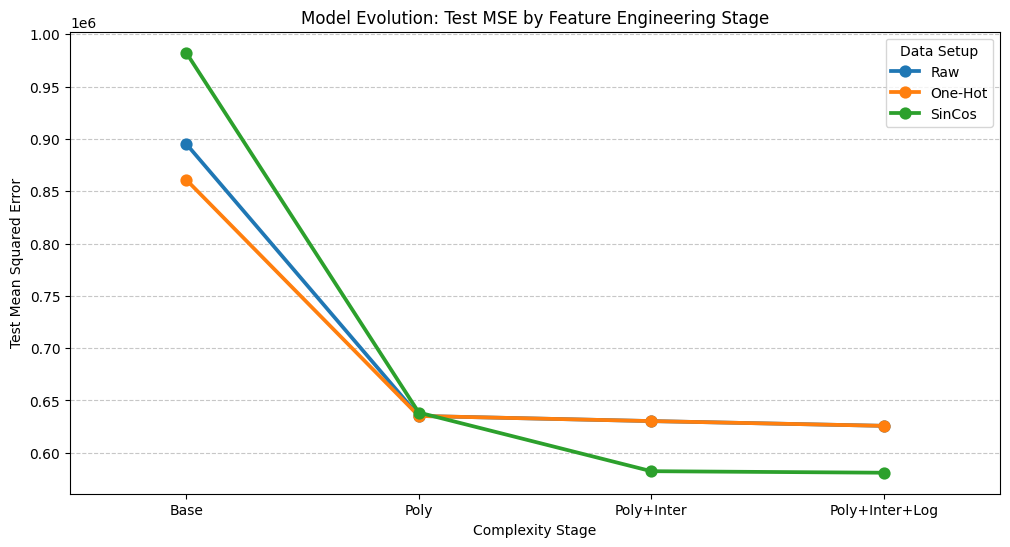

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(summary_df):
    plt.figure(figsize=(12, 6))

    # Lineplot to show the trend across FE stages
    sns.pointplot(data=summary_df, x='FE Stage', y='Test MSE', hue='Data Setup', markers="o", linestyles="-")

    plt.title('Model Evolution: Test MSE by Feature Engineering Stage')
    plt.ylabel('Test Mean Squared Error')
    plt.xlabel('Complexity Stage')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Run this after your compare() function
plot_results(summary)